## PERSIAPAN DATASET PRETRAIN MODEL T5 DENGAN DATASET UN-NORMALIZED


In [ ]:
!pip install -q transformers datasets pandas


In [ ]:
import pandas as pd

In [ ]:
df_unnormalized_for_SA = pd.read_csv('/content/dataset_text_untuk_pretrain_singkatan_SA-v1.csv')
df_unnorm_uncom_for_pretrain_T5 = pd.read_csv('/content/df_uncomppacted_unnormallized_for pretrain_indoT5.csv')

In [ ]:
df_gabung_unnorm = pd.concat([
    df_unnormalized_for_SA['text'],
    df_unnorm_uncom_for_pretrain_T5['ulasan']
], ignore_index=True).to_frame(name='text')


In [ ]:
df_gabung_unnorm.duplicated(subset='text',keep='first').sum()

In [ ]:
df_gabung_unnorm.drop_duplicates(subset='text',keep='first',inplace=True)

In [ ]:
df_gabung_unnorm.info()

## PRE-TRAIN MODEL DENGAN DATASET UNNORMALIZED

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# ========== STEP 1: Load dan Preprocess Dataset ==========
df = df_gabung_unnorm  # Dataset kamu (pastikan kolom "text" ada)

# Drop NaN
texts = df["text"].dropna()

# Filter: hanya ambil teks yang terdiri dari 7 kata atau lebih
texts = [t for t in texts if len(t.strip().split()) >= 7]
print(f"Number of texts with 6 or more words: {len(texts)}")

# Split data jadi training dan validation
train_texts, val_texts = train_test_split(texts, test_size=0.1, random_state=42)

# Buat Dataset dari dictionary
train_dataset = Dataset.from_dict({"text": train_texts})
val_dataset = Dataset.from_dict({"text": val_texts})

# ========== STEP 2: Tokenizer ==========
tokenizer = T5Tokenizer.from_pretrained("Wikidepia/IndoT5-base")

def tokenize_function(examples):
    model_inputs = tokenizer(examples["text"], truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["text"], truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenisasi train dan val dataset
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# ========== STEP 3: Load Model ==========
model = T5ForConditionalGeneration.from_pretrained("Wikidepia/IndoT5-base")

# ========== STEP 4: Data Collator ==========
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# ========== STEP 5: Training Arguments ==========
training_args = TrainingArguments(
    output_dir="./indot5-dapt",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_steps=1000,
    logging_steps=100,
    save_total_limit=2,
    prediction_loss_only=True,
    push_to_hub=False,
    report_to=[]  # Nonaktifkan logging ke luar (misal wandb)
)

# ========== STEP 6: Trainer ==========
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,         # <- tambahkan validasi dataset
    data_collator=data_collator,
    tokenizer=tokenizer                 # <- supaya log token juga bisa kebaca
)

# ========== STEP 7: Training ==========
trainer.train()

# ========== STEP 8: Save Model dan Tokenizer ==========
model.save_pretrained("./indot5-dapt")
tokenizer.save_pretrained("./indot5-dapt")


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
!kill -9 [PID]


## PERSIAPAN DATASET FINETUNE INDOT5

In [ ]:
!pip install gdown


In [ ]:
import gdown

file_id = "1ON4NH4qbjB230bEC0g8C3eRik-TkIL8j"
output = "indoT5-dapt.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)


In [ ]:
!unzip -q indoT5-dapt.zip -d indoT5-dapt

## FINETUNE DATASET gabungan unnorm dan norm

In [ ]:
import pandas as pd

In [ ]:
!pip install evaluate

In [ ]:
import torch
import pprint
import evaluate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import load_dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

pp = pprint.PrettyPrinter()


In [ ]:
pip install sentencepiece


Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/1638 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/182 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


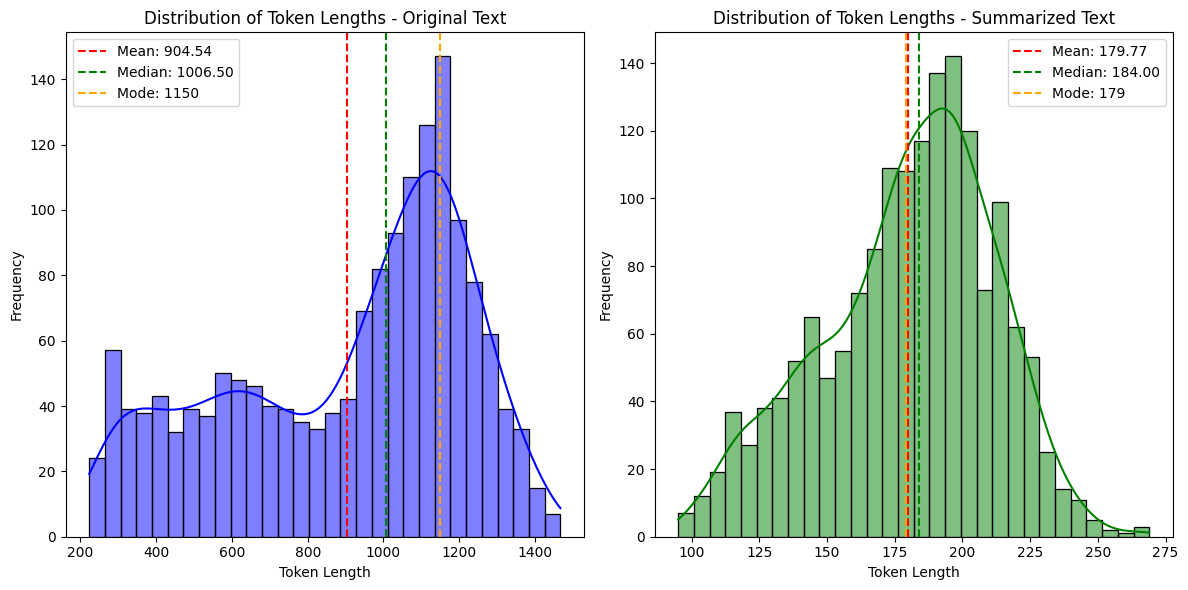

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasets import load_dataset
from transformers import T5Tokenizer
import math

######################################
# Prepare Dataset
######################################

# Load dataset dari CSV
dataset = load_dataset('csv', data_files='/kaggle/input/gabungan-asli-ama-sintesis-1000-smp-5000/sintesis_for_summarize_GABUNGAN DATA ASLI DAN SINTESIS_1000 to 5000.csv', split='train')
full_dataset = dataset.train_test_split(test_size=0.1, shuffle=True)
dataset_train, dataset_valid = full_dataset['train'], full_dataset['test']

# Load tokenizer IndoT5
MODEL = '/kaggle/working/indoT5-dapt/content/indot5-dapt/checkpoint-14682'
tokenizer = T5Tokenizer.from_pretrained(MODEL)

# Tambahkan prefix "summarize:" ke original_text
def add_prefix(example):
    example['original_text'] = "ringkaslah : " + example['original_text']
    return example

dataset_train = dataset_train.map(add_prefix)
dataset_valid = dataset_valid.map(add_prefix)

# Hitung panjang token
original_token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in dataset_train['original_text']]
summary_token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in dataset_train['summarized_text']]

# Fungsi preprocessing tokenizer
def preprocess_function(examples):
    inputs = examples['original_text']  # Sudah ada prefix "summarize:"
    model_inputs = tokenizer(inputs, truncation=True, padding=False)  # Tidak ada max_length

    targets = tokenizer(examples['summarized_text'], truncation=True, padding=False)
    model_inputs["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in targets["input_ids"]
    ]
    return model_inputs

# Tokenisasi
NUM_PROCS = 1
tokenized_train = dataset_train.map(preprocess_function, batched=True, num_proc=NUM_PROCS)
tokenized_valid = dataset_valid.map(preprocess_function, batched=True, num_proc=NUM_PROCS)

######################################
# Visualize Data Distribution
######################################

plt.figure(figsize=(12, 6))

# Plot Original Text
plt.subplot(1, 2, 1)
sns.histplot(original_token_lengths, bins=30, kde=True, color='blue')
plt.axvline(np.mean(original_token_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(original_token_lengths):.2f}')
plt.axvline(np.median(original_token_lengths), color='green', linestyle='--', label=f'Median: {np.median(original_token_lengths):.2f}')
mode_original = Counter(original_token_lengths).most_common(1)[0][0]
plt.axvline(mode_original, color='orange', linestyle='--', label=f'Mode: {mode_original}')
plt.title('Distribution of Token Lengths - Original Text')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()

# Plot Summarized Text
plt.subplot(1, 2, 2)
sns.histplot(summary_token_lengths, bins=30, kde=True, color='green')
plt.axvline(np.mean(summary_token_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(summary_token_lengths):.2f}')
plt.axvline(np.median(summary_token_lengths), color='green', linestyle='--', label=f'Median: {np.median(summary_token_lengths):.2f}')
mode_summary = Counter(summary_token_lengths).most_common(1)[0][0]
plt.axvline(mode_summary, color='orange', linestyle='--', label=f'Mode: {mode_summary}')
plt.title('Distribution of Token Lengths - Summarized Text')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ca8766f9dbfc589a0ab3bae419cf77e0f6da877e9c1ce2a4dc95e8d449932ab9
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [5]:
from torch.optim import AdamW


In [ ]:
from transformers import (
    get_linear_schedule_with_warmup, 
    T5Config, 
    T5ForConditionalGeneration, 
    T5Tokenizer,
    Trainer, 
    TrainingArguments, 
    DataCollatorForSeq2Seq,
)
import torch
import numpy as np
import evaluate
import datetime
import json

MODEL_NAME = "/kaggle/working/indoT5-dapt/content/indot5-dapt/checkpoint-14682"

# 1. Load Tokenizer
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

# 2. Load Model Configuration
config = T5Config.from_pretrained(MODEL_NAME, dropout_rate=0.2)

# 3. Load Model
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, config=config)
model.gradient_checkpointing_enable()  # Aktifkan Gradient Checkpointing

# 4. Pindahkan model ke device (DI SINI SEBELUM BUAT OPTIMIZER!)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 5. Cek parameter model
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# 6. Setup Metrics
rouge = evaluate.load("rouge")
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred.predictions, eval_pred.label_ids
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    valid_ids = np.arange(tokenizer.vocab_size)
    predictions = np.where(np.isin(predictions, valid_ids), predictions, tokenizer.pad_token_id)
    labels = np.where(np.isin(labels, valid_ids), labels, tokenizer.pad_token_id)

    flat_predictions = predictions.flatten()
    flat_labels = labels.flatten()
    mask = flat_labels != tokenizer.pad_token_id
    flat_predictions = flat_predictions[mask]
    flat_labels = flat_labels[mask]
    
    acc = accuracy.compute(predictions=flat_predictions, references=flat_labels)["accuracy"]

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=['rouge1', 'rouge2', 'rougeL']
    )

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens).item()
    result["accuracy"] = acc

    return {k: round(v, 4) for k, v in result.items()}

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        logits = logits[0]
    return torch.argmax(logits, dim=-1), labels

# 7. Hyperparameters
EPOCHS = 20
BATCH_SIZE = 4
gradient_accumulation_steps = 4

# 8. BUAT OPTIMIZER SETELAH MODEL DI PINDAHKAN KE DEVICE
optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01)

# 9. Setup Scheduler
total_steps = (len(tokenized_train) // BATCH_SIZE) * EPOCHS
warmup_steps = max(10, int(0.1 * total_steps))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# 10. Training Arguments
OUT_DIR = 'results_indot5-dapt-finetune-1'
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=gradient_accumulation_steps,
    warmup_steps=warmup_steps,
    weight_decay=0.01,
    logging_dir=OUT_DIR,
    label_smoothing_factor=0.05,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    report_to="tensorboard",
    dataloader_num_workers=2,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,
)

# 11. Data Collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=-100
)

# 12. Custom Callback
class EpochLoggingCallback:
    def __init__(self, log_file="training_logs.json"):
        self.log_file = log_file
        self.logs = []
        
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            epoch_log = {
                "epoch": state.epoch,
                "step": state.global_step,
                "timestamp": datetime.datetime.now().isoformat(),
                "metrics": metrics
            }
            self.logs.append(epoch_log)
            
            with open(self.log_file, "w") as f:
                json.dump(self.logs, f, indent=2)

# 13. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    optimizers=(optimizer, scheduler)
)

# 14. Start Training
trainer.train()

2025-05-14 01:33:03.335276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747186383.360494     116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747186383.367906     116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


247,577,856 total parameters.
247,577,856 training parameters.


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Gen Len,Accuracy
1,5.200200,4.614876,0.349700,0.056800,0.217700,206.022000,0.261700
2,4.287300,3.788069,0.454300,0.100800,0.300800,199.033000,0.354900
3,3.669400,3.178185,0.531000,0.168200,0.391600,185.483500,0.448800
4,3.246500,2.831177,0.580500,0.221200,0.451400,180.346200,0.504400
5,3.050300,2.653624,0.602900,0.254600,0.481300,176.884600,0.535300
6,2.866500,2.535953,0.614300,0.269600,0.498500,179.115400,0.553300
7,2.755900,2.444266,0.626400,0.288800,0.515800,183.774700,0.570700
8,2.637400,2.369361,0.634400,0.299100,0.526200,185.670300,0.581500
9,2.576100,2.310642,0.584000,0.281100,0.487500,206.120900,0.594000
10,2.376900,2.262848,0.589500,0.289600,0.496400,206.120900,0.602800


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


In [7]:
# Save final model and tokenizer
model.save_pretrained(OUT_DIR)
tokenizer.save_pretrained(OUT_DIR)

('results_indot5-dapt-finetune-1/tokenizer_config.json',
 'results_indot5-dapt-finetune-1/special_tokens_map.json',
 'results_indot5-dapt-finetune-1/spiece.model',
 'results_indot5-dapt-finetune-1/added_tokens.json')

In [24]:
!zip -r /kaggle/working/model-indot5-finetuned-fase3-epoch20-yang kedua.zip /kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040


	zip warning: name not matched: kedua.zip
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/ (stored 0%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/added_tokens.json (deflated 83%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/generation_config.json (deflated 29%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/scheduler.pt (deflated 54%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/rng_state.pth (deflated 25%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/tokenizer_config.json (deflated 94%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/model.safetensors (deflated 10%)
  adding: kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/config.json (deflated 48%)
  adding: kaggle/working/results_

In [9]:
import json

with open("/kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/trainer_state.json", "r") as f:
    state = json.load(f)

# Tampilkan semua isi JSON dengan format yang mudah dibaca
print(json.dumps(state, indent=2))


{
  "best_global_step": 2040,
  "best_metric": 0.5303,
  "best_model_checkpoint": "results_indot5-dapt-finetune-1/checkpoint-2040",
  "epoch": 19.809756097560975,
  "eval_steps": 500,
  "global_step": 2040,
  "is_hyper_param_search": false,
  "is_local_process_zero": true,
  "is_world_process_zero": true,
  "log_history": [
    {
      "epoch": 0.0975609756097561,
      "grad_norm": 28.591365814208984,
      "learning_rate": 1.1002444987775063e-06,
      "loss": 7.0785,
      "step": 10
    },
    {
      "epoch": 0.1951219512195122,
      "grad_norm": 12.880611419677734,
      "learning_rate": 2.3227383863080683e-06,
      "loss": 7.0553,
      "step": 20
    },
    {
      "epoch": 0.2926829268292683,
      "grad_norm": 12.526750564575195,
      "learning_rate": 3.545232273838631e-06,
      "loss": 6.7418,
      "step": 30
    },
    {
      "epoch": 0.3902439024390244,
      "grad_norm": 12.294014930725098,
      "learning_rate": 4.767726161369193e-06,
      "loss": 6.5119,
      "s

In [8]:
from collections import defaultdict
import json

# Load trainer_state.json
with open("/kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040/trainer_state.json", "r") as f:
    state = json.load(f)

# Siapkan penampung loss per epoch
epoch_losses = defaultdict(list)

# Ambil log training
for log in state["log_history"]:
    if "loss" in log and "epoch" in log:
        epoch = int(log["epoch"])  # Dibulatkan ke bawah
        loss = log["loss"]
        epoch_losses[epoch].append(loss)

# Hitung rata-rata loss per epoch
for epoch in sorted(epoch_losses.keys()):
    avg_loss = sum(epoch_losses[epoch]) / len(epoch_losses[epoch])
    print(f"Epoch {epoch}: Loss rata-rata = {avg_loss:.4f}")


Epoch 0: Loss rata-rata = 6.1088
Epoch 1: Loss rata-rata = 4.6168
Epoch 2: Loss rata-rata = 3.8977
Epoch 3: Loss rata-rata = 3.3821
Epoch 4: Loss rata-rata = 3.0858
Epoch 5: Loss rata-rata = 2.9084
Epoch 6: Loss rata-rata = 2.7742
Epoch 7: Loss rata-rata = 2.6646
Epoch 8: Loss rata-rata = 2.5724
Epoch 9: Loss rata-rata = 2.4930
Epoch 10: Loss rata-rata = 2.4360
Epoch 11: Loss rata-rata = 2.3773
Epoch 12: Loss rata-rata = 2.3336
Epoch 13: Loss rata-rata = 2.2972
Epoch 14: Loss rata-rata = 2.2564
Epoch 15: Loss rata-rata = 2.2219
Epoch 16: Loss rata-rata = 2.1919
Epoch 17: Loss rata-rata = 2.1627
Epoch 18: Loss rata-rata = 2.1371
Epoch 19: Loss rata-rata = 2.1057


## INFERENSIA

In [10]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

import glob

model_path = f"/kaggle/working/results_indot5-dapt-finetune-1/checkpoint-2040"  # the path where you saved your model, higher is better
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [14]:
import pprint # Import the pprint module
pp = pprint.PrettyPrinter()

In [15]:
def summarize_text(text, model, tokenizer, num_beams=80, no_repeat_ngram_size=2):
    # Preprocess input text
    inputs = tokenizer.encode(
        f'ringkaslah: {text}', return_tensors='pt', max_length=1400,
        truncation=True
    ).to(device)
    # Generate summary
    summary_ids = model.generate(
        inputs,
        max_length=270,
        min_length=100,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        repetition_penalty=2.0,
        length_penalty=1.0,
        early_stopping=True
    )

    # Decode hasil dari id-token ke teks
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [16]:
# Contoh penggunaan
contoh_text = """
    "Keripiknya garing bgt, cocok buat ngemil saat lagi santai. Rasanya juga pas, ga terlalu asin atau gurih.",
    "Packingnya rapih, keripiknya tetep crispy meski udah sampai di rumah. Harga sesuai sama kualitas.",
    "Rasa bumbunya mantap, gurih dan ada sedikit pedasnya, bikin ketagihan. Gak bosen dimakan terus.",
    "Minyaknya juga gak berlebihan, keripiknya masih kering dan enak, bener-bener fresh.",
    "Keripiknya gede-gede dan gak ada yang remuk, bener-bener full isi, enak banget pas digigit.",
    "Porsinya pas, nggak kurang dan nggak berlebihan. Cocok buat ngemil rame-rame atau nonton film.",
    "Bumbunya nempel merata, jadi setiap gigitan keripiknya rasa banget, enak dan gurih.",
    "Rasanya juga seimbang, ada manis sedikit, gurih, dan pedas. Pas banget di lidah.",
    "Kemasan kedap udara, jadi keripiknya tetap awet dan gak lembek meski udah beberapa hari dibuka.",
    "Aroma pas buka kemasan langsung wangi, bikin makin lapar. Ga ada bau aneh, fresh banget.",
    "Teksturnya garing dan crunchy, gak keras, enak banget dimakan. Bikin nagih deh.",
    "Saus tomatnya pas, ada rasa manisnya, tapi nggak berlebihan. Balance sama keripiknya.",
    "Porsinya cukup banyak, bisa buat share ke temen-temen. Rasanya juga pas di semua lidah.",
    "Keripiknya gak terlalu tipis, jadi pas digigit ada tekstur yang enak, nggak gampang remuk.",
    "Bumbunya pas banget, ada rasa pedas dan sedikit asin, bikin makan jadi lebih nikmat.",
    "Kemasan praktis, gak ribet dibuka, dan keripiknya tetep crispy sampe habis.",
    "Keripiknya enak, garing, dan gurih banget. Kualitasnya gak kalah sama yang premium.",
    "Setelah dibuka, keripiknya tetap crunchy, gak lembek kayak produk lain. Enak banget.",
    "Bungkusnya kuat, nggak ada yang rusak. Pas sampai, keripiknya masih utuh dan fresh.",
    "Bumbunya enak banget, meresap ke dalam keripiknya, jadi setiap gigitan kerasa banget rasanya.",
    "Rasa pedasnya cocok buat yang suka makanan sedikit pedas, gak nyiksa, tapi enak banget.",
    "Harga sebanding sama kualitas, keripiknya gede dan penuh bumbunya. Bener-bener worth it.",
    "Makan keripik ini ngerasa kayak lagi nyemil makanan premium, gurihnya bener-bener pas.",
    "Tebelnya pas, nggak keras, dan nggak lembek. Pas banget dimakan sambil ngobrol sama temen.",
    "Bumbunya ringan tapi berasa, gak bikin eneg meski makan banyak. Pas banget buat ngemil.",
    "Keripiknya seger banget, bahkan di hari kedua setelah dibuka, masih garing.",
    "Ada variasi rasa yang bisa dicoba, jadi nggak bosen. Setiap rasa punya karakter sendiri.",
    "Cocok banget buat ngemil sambil nonton film, keripiknya nggak berasa berminyak.",
    "Keripiknya crispy dan lezat, gak ada yang gosong. Bumbunya juga pas, gak terlalu pedas.",
    "Keripiknya nggak nyisa minyak, garing dan tetep enak meski udah beberapa jam setelah buka.",
    "Gak ada bagian keripik yang keras banget atau gosong, semua terasa fresh dan enak.",
    "Bungkusnya kecil, praktis dibawa kemana-mana, cocok buat ngemil pas lagi jalan-jalan.",
    "Keripiknya gak cuma garing, tapi juga ada rasa manis gurih yang bikin ketagihan.",
    "Keripiknya tebal-tebal, jadi rasa keripiknya lebih berasa dibanding keripik tipis biasa.",
    "Rasa pedasnya ringan, cocok banget buat yang suka makanan nggak terlalu pedas tapi tetap enak.",
    "Harga oke banget, kualitas keripiknya juga premium, worth it banget buat dibeli lagi."

"""
hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Secara keseluruhan, ulasan untuk keripik ini sangat positif dan menunjukkan '
 'kepuasan pelanggan yang tinggi. Pelanggan secara konsisten memuji tekstur '
 'keripik yang renyah dan renyah, tidak lembek seperti produk lain, serta '
 'bumbu yang meresap merata ke dalam keripik, menjadikannya ideal untuk '
 'berbagai aktivitas seperti bersantai, menonton film, atau sekadar menikmati '
 'makanan premium. Kemudahan penggunaan kemasan juga menjadi poin penting yang '
 'diapresiasi, dengan banyak pelanggan menyebutkan kemasan yang kedap udara '
 'sebagai nilai tambah. Selain rasa, kualitas keripik dinilai sebanding dengan '
 'harga yang ditawarkan, bahkan beberapa menyebutnya sepadan dengan kualitas '
 'yang diberikan. Pengemasan yang rapi dan kerapian kemasan turut menambah '
 'kenyamanan saat digunakan. Banyak pelanggan menyatakan bahwa keripik tetap '
 'fresh setelah dibuka, memberikan pengalaman ngemil yang menyenangkan bagi '
 'sebagian besar orang lain. Kesimpulannya, produk ini mena

In [17]:
# Contoh penggunaan
contoh_text = """
    "Teksturnya keras bgt, nyaris gak bisa digigit. Pake gigi sampe sakit deh, udah gitu nggak garing juga.",
    "Keripiknya remuk semua, kemasan kebanyakan kosong. Cuma dapet remahan, nggak worth it sama harganya.",
    "Rasa bumbunya kebanyakan, sampe eneg. Gak ada balance antara rasa asin dan gurihnya, bener-bener gak enak.",
    "Minyaknya masih nempel bgt di keripik, lengket di jari. Gak ada rasa fresh, kayak udah lama disimpen.",
    "Expired tinggal seminggu, baru nyampe! Masa gak ada perhatian soal stok. Harusnya lebih hati-hati ngirimnya.",
    "Porsinya dikit banget, nggak sebanding sama harga. Cuma 1/3 bungkus yang penuh, selebihnya kosong.",
    "Bumbunya gak rata, ada bagian yang asin banget, ada yang kosong gitu aja. Gak enak dimakan bareng.",
    "Kemasan gampang sobek, pas buka malah bocor. Angin masuk, keripiknya jadi lembek.",
    "Keripiknya pahit, kayak gosong gitu, bener-bener gak enak dimakan. Udah coba beberapa, tetep sama rasanya.",
    "Aromanya aneh, bau kayak tengik atau apek. Padahal expired masih jauh, ini gak banget.",
    "Keripiknya terlalu tebel, susah dimakan. Bikin gigi lelah, beda sama yang di iklan.",
    "Pedasnya gak ada kerasa, malah bumbunya kurang nendang. Rasanya flat aja, ga bikin nagih.",
    "Pas makan, malah nemu serpihan plastik kecil. Gak bisa dilanjutin, langsung dibuang semua.",
    "Bentuk keripiknya aneh, ga konsisten. Ada yang tebel, ada yang tipis. Bikin makan jadi nggak nyaman.",
    "Keripiknya warnanya pucet, kayak gak digoreng dengan bener. Gak ada rasa crispy kayak yang dijanjikan.",
    "Bungkus dalamnya berminyak banget, sampe nempel-nempel keripiknya. Gak segar sama sekali.",
    "Rasa kejunya malah mirip susu basi. Gak enak, bahkan keripiknya sendiri udah gak enak.",
    "Pas buka kemasan, bau aneh banget. Kayak apek gitu, padahal udah jauh dari tanggal expired.",
    "Bumbunya cuma nempel di dasar bungkus, keripiknya hambar banget. Rasanya kayak keripik basi.",
    "Keripiknya keras, gak cocok buat orang tua atau anak kecil. Susah digigit, malah bikin sakit gigi.",
    "Keripiknya gak garing, malah lembek. Pas makan rasanya kayak udah lama disimpen.",
    "Bungkusnya susah dibuka, apalagi pas udah dibuka, keripiknya udah nggak fresh lagi.",
    "Rasa asin di keripiknya aneh, kayak ada bahan kimia atau pengawetnya. Gak nyaman di lidah.",
    "Coklatnya terlalu manis dan gak cocok sama keripiknya. Rasanya jadi aneh banget.",
    "Keripiknya habis 5 menit langsung eneg, gak bisa abisin. Rasanya nempel lama di mulut.",
    "Cuma ada 2 rasa doang di dalam varian, gak ada variasi, bosen banget.",
    "Keripiknya gak crunchy, malah lembek. Semua keripik jadi nempel satu sama lain.",
    "Pas dicoba, ada bagian keripik yang keras banget, kayak udah kebakar. Ga bisa dimakan.",
    "Kurang pedasnya, gak ada rasa gigitannya. Gak ada sensasi yang bikin nagih.",
    "Bungkusnya gak rapet, pas dibuka udah pada kempes. Keripiknya jadi gak enak lagi.",
    "Bumbunya kurang meresap, jadi banyak bagian yang rasanya hambar. Gak worth the price.",
    "Keripiknya ngelotok banget, nyaris ga ada rasa bumbunya sama sekali. Cuma keripik gorengan biasa.",
    "Rasa tomatnya garing, dan keasinannya bikin tenggorokan kering. Kebanyakan garam deh.",
    "Waktu buka kemasan, keripiknya udah hancur-hancur semua. Gak bisa nikmatin keripiknya.",
    "Ada bagian keripik yang rasanya gosong, bener-bener bikin males makan sisa bungkusnya.",
    "Teksturnya garing, tapi rasanya malah kayak tengik gitu. Udah nggak enak pas makan.",
    "Coklatnya kemanisan, gak ada keseimbangan sama keripiknya. Bikin eneg, malah ga habis.",
    "Bungkusnya penuh minyak, keripiknya jadi lempung, gak ada rasa fresh lagi.",
    "Keripik ini tebel-tebel, kerasnya bukan karena garing, tapi karena nggak digoreng bener."
"""
hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Ulasan terhadap keripik ini secara konsisten menunjukkan kekecewaan mendalam '
 'dari para pembeli. Keluhan utama berpusat pada tekstur keripik yang sangat '
 'keras, seringkali digambarkan seperti lembek, tipis, atau bahkan gosong, '
 'jauh dari harapan rasa fresh yang dijanjikan. Banyak pelanggan melaporkan '
 'bahwa keripik tidak dapat digigit dengan baik, bahkan ada yang mengalami '
 'sakit gigi setelah mengonsumsinya. Tekstur keripik juga menjadi perhatian '
 'utama, dengan banyak laporan mengenai serpihan plastik kecil yang '
 'menyebabkan keripik mudah sobek atau kempes meskipun sudah melewati tanggal '
 'kedaluwarsa, namun hal ini tidak sebanding dengan harga yang ditawarkan. '
 'Selain masalah rasa, beberapa pembeli juga mengeluhkan rasa keju yang '
 'terlalu manis dan aroma yang tidak sedap, memperburuk pengalaman makan '
 'mereka. Secara keseluruhan, produk ini dinilai tidak memberikan nilai yang '
 'sepadan dengan harganya, terutama bagi orang tua atau anakanak, sehingga 

In [18]:
# Contoh penggunaan
contoh_text = [
    "Rasanya kayak air gula doang, gak ada rasa buahnya sama sekali. Hambar banget.",
    "Pas dibuka, aromanya kayak obat batuk. Langsung ilfil, gak jadi diminum.",
    "Minumannya datar, gak ada karbonasinya. Padahal labelnya bilang soda.",
    "Kemasan bocor, isinya udah netes-netes pas sampe. Setengah isinya hilang.",
    "Manisnya lebay, bikin tenggorokan gatel. Minum dikit aja udah eneg.",
    "Expired tinggal beberapa hari, dikirim kayak gitu aja. Gak tanggung jawab.",
    "Ada endapan aneh di bawah botol, kayak bekas susu basi. Jijik banget liatnya.",
    "Rasa lemonnya malah kayak sabun cuci piring. Beneran gak bisa ditelen.",
    "Pas diminum dingin juga gak nyegerin, rasanya kayak air bekas rendaman permen.",
    "Gak sesuai ekspektasi, rasa kopi susu-nya lebih ke rasa air kopi encer.",
    "Botolnya penyok semua, gak bisa ditutup rapat. Ngeri tumpah terus.",
    "Ada rasa pahit gak jelas di akhir tegukan, kayak ada bahan kimia gitu.",
    "Pas dicium dari gelas, baunya kayak plastik. Gak fresh sama sekali.",
    "Minumannya keruh, warnanya pun aneh. Kayak bukan buat diminum.",
    "Udah shake berkali-kali, tapi rasa tetep gak rata. Manis di bawah doang.",
    "Rasa matcha-nya terlalu artifisial, lebih mirip bubuk instan murahan.",
    "Minuman dingin, tapi dikirim tanpa pendingin. Sampe-sampe udah berubah rasa.",
    "Kemasannya susah dibuka, harus pake pisau. Ribet banget.",
    "Minumannya terlalu kental, kayak minum sirup tanpa diencerin.",
    "Rasa buah campurnya malah bikin mual, gak jelas perpaduannya.",
    "Karbonasinya lebay, baru buka udah muncrat kemana-mana.",
    "Warnanya ngejreng banget, keliatan full pewarna. Rasa juga gak natural.",
    "Pas dicoba, tenggorokan langsung gatel. Gak cocok sama sekali.",
    "Katanya susu stroberi, tapi yang kerasa cuma rasa susu basi.",
    "Dibilang 'less sugar', tapi manisnya kayak 10 sendok gula.",
    "Minuman coklatnya terlalu encer, gak creamy sama sekali.",
    "Botolnya gampang tumpah, tutupnya longgar banget.",
    "Rasa jeruknya kayak permen asam basi. Gak nyegerin sama sekali.",
    "Ada partikel kecil kayak pasir waktu diminum. Gak paham itu apa.",
    "Rasanya datar banget, bahkan air galon lebih seger dari ini.",
    "Pas diminum, lidah jadi kesemutan. Kayak ada reaksi aneh gitu.",
    "Kemasannya keren, tapi isinya jauh dari ekspektasi. Cuma modal desain.",
    "Minuman ini rasanya berubah banget dari dulu. Sekarang hambar total.",
    "Disimpan di kulkas pun rasanya tetep gak enak. Gak ada efek nyegerin.",
    "Rasa coklat mint-nya kayak odol cair. Gak pantes jadi minuman.",
    "Botolnya bau, bahkan sebelum dibuka. Kayak ada bahan kimia menyengat.",
    "Rasa anggurnya terlalu tajam, gak balance sama rasa lainnya.",
    "Minum ini bikin perut kembung parah. Gak tau ada apa di dalemnya.",
    "Pas diminum, kayak ada rasa plastik. Mungkin karena botolnya jelek.",
    "Labelnya bilang segar, tapi rasanya kayak minuman udah 3 hari dibuka."
]

hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Ulasan terhadap minuman ini secara konsisten menunjukkan kekecewaan mendalam '
 'dari para pembeli. Keluhan utama berpusat pada rasa manis yang berlebihan, '
 'seringkali digambarkan seperti air gula atau soda, jauh dari ekspektasi rasa '
 'kopi susu yang sebenarnya. Banyak pelanggan melaporkan efek samping seperti '
 'mual, kesemutan, dan ketidaknyamanan setelah mengonsumsinya. Selain itu, '
 'terdapat keluhan mengenai kualitas kemasan yang buruk, dengan banyak laporan '
 'mengenai botol penyok, tutup yang longgar, serta aroma yang tidak sedap dan '
 'menyerupai obat batuk. Beberapa pembeli juga menyoroti adanya endapan kecil '
 'di bawah botol, mengindikasikan adanya bahan kimia yang menyengat. Meskipun '
 'beberapa menyebutkan produk ini dianggap sebagai less sugar, hal ini tidak '
 'memberikan nilai yang sepadan dengan harga yang ditawarkan. Secara '
 'keseluruhan, mayoritas ulasan menyoroti masalah pengemasan yang perlu segera '
 'ditangani oleh pemilik toko untuk memulihkan kep

In [19]:
contoh_text = [
    "Empuk banget! Begitu digigit langsung lumer di mulut. Gak seret sama sekali.",
    "Rasa manisnya pas, gak lebay. Cocok buat temen ngopi sore-sore.",
    "Aromanya wangi banget, begitu buka kemasan langsung kecium harum vanilla.",
    "Teksturnya lembut dan moist. Bahkan tanpa topping pun udah enak banget.",
    "Packing-nya rapi, nyampe gak penyok, dan bolunya tetep fresh!",
    "Varian rasa coklatnya juara sih, gak terlalu manis tapi deep banget rasa coklatnya.",
    "Ada sensasi buttery yang bikin nagih. Kaya rasa premium bakery.",
    "Gak nyangka, bolu rumahan tapi kualitasnya ala cafe mahal.",
    "Lapisan luarnya agak crunchy, dalemnya super lembut. Perpaduan yang sempurna!",
    "Porsinya pas, gak kebanyakan tapi cukup bikin puas ngemil.",
    "Tiap gigitan konsisten enaknya, gak ada bagian yang kering atau keras.",
    "Rasa kejunya dapet banget! Lumer dan creamy di bagian tengah.",
    "Manisnya elegan, bukan tipe yang bikin eneg. Justru pengen nambah terus.",
    "Waktu dipanasin sebentar, wanginya makin keluar dan teksturnya makin empuk.",
    "Cocok buat bekal atau hampers, tampilannya juga cantik banget.",
    "Ga nyangka bolu biasa bisa seenak ini. Jadi langganan deh!",
    "Tahan lama tanpa bahan pengawet. Masih enak walau udah 2-3 hari disimpan.",
    "Cocok buat semua umur, orang tua juga suka karena gak terlalu manis.",
    "Ada rasa pisangnya yang natural, bukan rasa essence. Fresh banget!",
    "Teksturnya fluffy, bahkan anak-anak pun gampang ngunyahnya.",
    "Bolu pandan-nya harum dan lembut, rasa tradisional yang ngangenin.",
    "Walau dikirim dari luar kota, pas nyampe tetap moist dan gak keras.",
    "Rasa original-nya aja udah enak. Gak butuh topping tambahan apa-apa.",
    "Nyobain satu potong doang malah keterusan, gak bisa stop.",
    "Cocok banget dijadiin oleh-oleh, semua yang nyobain pasti suka.",
    "Warna bolunya cantik, gak lebay, dan alami. Eye-catching tapi tetap menggoda.",
    "Dari tampilannya aja udah bikin ngiler. Begitu dicoba, lebih dari ekspektasi.",
    "Manisnya dapet, tapi masih ada aftertaste gurih dari telurnya. Enak banget!",
    "Bolu ini sukses bikin nostalgia masa kecil, rasanya klasik tapi tetep relevan.",
    "Teksturnya spongy banget. Diteken balik lagi. Bukti bolunya fresh!",
    "Rasa dan kualitasnya konsisten dari dulu. Gak pernah mengecewakan.",
    "Pas disajikan buat tamu, langsung pada nanya beli di mana. Laku keras!"
]

hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Secara keseluruhan, ulasan untuk bolu ini sangat positif dan menunjukkan '
 'kepuasan pelanggan yang tinggi. Pelanggan secara konsisten memuji teksturnya '
 'yang empuk dan lembut, bahkan tanpa topping tambahan, menjadikannya pilihan '
 'ideal untuk berbagai kalangan, mulai dari anakanak hingga orang tua. Rasa '
 'manis yang pas dan creamy menjadi daya tarik utama, dengan banyak yang '
 'menyebutnya sebagai rasa premium bakery. Kemudahan mengunyah juga menjadi '
 'poin penting yang diapresiasi, terutama saat disajikan sebagai bekal atau '
 'hampers. Pengiriman cepat dan pengemasan yang rapi juga berkontribusi pada '
 'pengalaman berbelanja yang menyenangkan. Beberapa pelanggan bahkan '
 'menyatakan niat untuk membeli produk ini sebagai hadiah atau oleh tamu. '
 'Meskipun ada sedikit keluhan mengenai kemasan yang penyok, hal ini tidak '
 'mengurangi kepuasan bagi sebagian besar pembeli. Kesimpulannya, kue ini '
 'menawarkan nilai yang sepadan dengan harganya, namun tetap memenuhi '
 '

In [20]:
# Contoh penggunaan
contoh_text = """ Hp ini bgs bgt sih, speknya mantep bwt main game ato nonton drakor. Layarnya gede, warnanya jernih bgt. Udah dipake 6 bulanan msh ngacir aja, baterenya awet pula. Kamera juga bening, cocok bwt foto2. Pokoknya puas deh beli A71 ini. Dari awal buka dus udah keliatan elegan. Body slim, enak digenggam. UI-nya smooth, ga ada lag. Kamera ultra wide-nya keren bgt, hasilnya tajem. Buat selfie juga kece. Suara speaker lumayan nendang. Worth it lah harganya! Beli A71 pas promo, dapet harga miring. Performanya oke bgt, Snapdragon-nya gahar. Multitasking aman, buka banyak app ga bikin nge-lag. Layarnya AMOLED, bikin nonton jd lebih seru. Baterai awet, ngecas cepet. Ga nyesel beli ini! Udah coba bbrp hp midrange, tp A71 ini paling cucok! RAM gede, cocok bwt kerjaan dan hiburan. Kamera 64MP-nya cakep bgt, hasil jepretan bening. Ada fitur NFC jg, jadi gampang isi saldo e-money. Pokoknya lengkap banget! Waktu dtg, hp-nya keren bgt! Build quality solid. Buat main ML sama PUBG aman jaya, grafik rata kanan lancar jaya. Layarnya gede tp enteng di tangan. UI-nya simple, ga ribet. Aplikasi dibuka2 ga ada hambatan. Recomended pokoknya! Desain A71 tuh cakep bgt, mewah kyk hp flagship. Udah pake sebulan, ga ada kendala. Kamera malamnya juga keren, low light tetep cling. Fingerprint cepet ngerespon. Pokoknya ini hp cakep bgt buat kelas harga segini. Suka bgt sama layarnya, super AMOLED emg gk ada lawan. Warna gonjreng, cerah maksimal. Buat nonton YouTube atau Netflix jd makin mantap. UI OneUI nya smooth bgt, minim bug. Aplikasi kerjaan juga lancar semua. Puas deh! A71 ini enak bgt buat daily driver. Ringan, nyaman di tangan, performa ngebut. Kamera belakang jernih bgt, selfie juga ga kalah. Baterai tahan sampe seharian penuh, udah gitu fast charging-nya cepet! Cocok buat yg aktif. Gile sih, A71 worth it bgt buat harga segini. Desainnya keren, layar luas bgt. RAM lega, penyimpanan juga gede. Main game aman, buka app cepet. Kamera ultra wide-nya cakep, bisa foto pemandangan lbh luas. Mantap bgt dah! Baru pake 2 minggu, udah jatuh cinta. Touchscreen responsif, ga lemot sama skali. Kamera bgs, ada mode pro jg. Suara speaker jernih. Pake buat Zoom jg stabil. Udah 2025, tapi hp ini msh bisa diandelin bgt! Udah coba edit video pake A71, ternyata lancar jaya. Layarnya gede, bikin proses editing nyaman. Kameranya bgs bgt buat rekam konten. Pake social media lancar, ga ada patah2. Pokoknya content creator wajib coba ini! A71 ini bener2 cocok buat multitasking. RAM-nya lega, bisa buka 4-5 app tanpa patah. Kamera selfie bgs, hasilnya natural. Baterai 4500mAh tahan seharian, fast charging juga ngebut. Udah gitu tampilannya juga elegan! Hp ini enak bgt buat dipake nonton dan gaming. Visualnya bener2 tajem, speakernya oke. Main game grafik tinggi juga aman. UI-nya user friendly, ga ribet. Dapet fitur kekinian semua. Buat harga segini mah top bgt! Awalnya ragu beli, tp ternyata A71 memuaskan. Desain slim, gampang dimasukin kantong. Ngecas cuma 1 jam-an udah full. Kamera belakangnya ajib buat foto sunset. Koneksi internet juga stabil. Pake tiap hari tanpa masalah! Jatuh cinta ama layar AMOLED-nya. Warnanya bener2 pop out. Main IG, TikTok, scrolling jd makin seru. Udah ada NFC jg, jadi makin praktis. Ga ngelag walau dipake lama. Udah sekelas flagship, tp harga midrange. Sip dah! HP ini tuh nyaman bgt dipake, enteng dan nggak gampang panas. Buat zoom meeting atau kerja remote lancar jaya. Kamera oke, bisa buat scan dokumen jg. Ga rewel dipake seharian. Buat kerja dan hiburan pas bgt! Udah 1 tahun pake A71, performanya msh stabil. Update software juga rutin. Kamera makin bgs tiap update. Fingerprint cepet, face unlock juga responsif. Ga nyangka hp ini bisa tahan lama dan tetep smooth. Bgs bgt! Pake A71 tuh berasa pegang hp flagship. Multitasking, gaming, nonton film semua lancar. Layarnya besar tp ringan, body tipis. Hasil kamera memuaskan. Bisa diajak kerja berat juga. Buat pelajar ato kerjaan cocok bgt. Yang paling gue suka tuh kameranya! Mode malamnya bikin foto jd estetik bgt. Layarnya bikin mata betah, warnanya tajem. Baterai tahan lama, dan ngecasnya ngebut. Cek harga pas diskon, langsung borong deh. Worth it 100%! Udah banyak hp yg gue coba, tp A71 ini salah satu yg terbaik. Ringan, performa stabil, layar luas dan terang. Kamera ultra wide dan makro jg bgs. Udah ada fast charging, fingerprint under display pula. Sempurna buat daily! """

hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Secara keseluruhan, ulasan untuk A71 sangat positif dan menunjukkan kepuasan '
 'tinggi dari para pembeli. Hampir seluruh pengguna menyoroti performa '
 'multitasking yang lancar, baik untuk tugastugas dasar seperti bermain game, '
 'menonton drakor, maupun pekerjaan remote control. Kualitas kamera juga '
 'menjadi poin penting yang diapresiasi, dengan banyak pengguna melaporkan '
 'hasil jepretan yang jernih dan tajam, bahkan dalam kondisi minim cahaya. '
 'Layar AMOLED yang luas dan responsivitas fingerprint under display menjadi '
 'nilai tambah signifikan, memberikan pengalaman visual yang estetik dan '
 'imersif, terutama saat digunakan untuk penggunaan seharihari, serta fitur '
 'NFC yang memudahkan pengisian saldo e-money. Banyak pengguna menyatakan '
 'bahwa ponsel ini menawarkan nilai yang sepadan dengan harganya, '
 'menjadikannya pilihan ideal bagi mereka yang mencari perangkat kelas '
 'flagship dengan harga terjangkau. Selain performa, daya tahan baterai yang '
 'awet, k

In [21]:
contoh_text = """ Baru beli A71, ekspektasi tinggi, eh malah zonk. Layarnya emang AMOLED, tapi gampang ghost touch. Sering banget buka app sendiri. Kamera 64MP katanya sih bening, kenyataannya pas low light malah burem total. Batre juga boros parah, apalagi kalo dipake hotspot. Udah gitu kadang suka panas sendiri, padahal cuma buat buka WA doang. Belum sebulan pakai udah mulai kerasa lag pas multitasking, buka IG sama TikTok aja suka patah2. Kecewa sih, harga segini harusnya dapet pengalaman yg lebih bgs. Suara speakernya juga cempreng, buat nonton YouTube suaranya kadang pecah, padahal volume nggak full. Fingerprint-nya lemot, kadang mesti dicoba 2-3x baru kebuka. Pas dipake ngetik juga delay-nya ngeselin. UI-nya kadang force close sendiri, apalagi pas update aplikasi. Main game? Dikit-dikit drop fps, ML aja bisa patah2 tengah war. Udah coba reset juga tetep sama aja. Dulu pernah pake seri A lainnya, tapi A71 ini malah yg paling sering bermasalah. Build quality-nya juga terasa ringkih, jatuh dikit langsung ada goresan. Charger bawaannya juga nggak selalu ngisi cepet, kadang stuck di 50% lama bgt. Kameranya overhype, realitanya hasil foto kalah sama hp 2jt-an. RAM besar sih, tapi percuma kalo manajemen memorinya amburadul. Terkesan lemot meskipun app-nya dikit. Pake zoom meeting sering disconnect, sinyalnya suka loncat2 padahal pake WiFi rumahan. Sudah update ke firmware terbaru tapi masalah tetap sama. Layanan servis Samsung juga kurang memuaskan, bawa ke SC cuma disuruh reset. Ga dikasih solusi yg jelas. Layar lebar sih iya, tapi responsivitasnya jauh dari harapan. Kadang mau scroll malah ga jalan. Paket pengiriman dari seller juga lama, dan ga dapet bonus apapun. Udah mahal, fitur seadanya. Belinya pas flash sale, ekspektasi tinggi, ternyata yaa gitu deh. HP midrange rasa entry level. Banyak bug kecil yg lama-lama nyebelin. UI-nya kadang freeze pas multitasking. Update software-nya juga lambat, patch keamanan ketinggalan bbrp bulan. Dipake seharian bisa bikin frustasi. Nyoba game Genshin aja langsung panas kayak setrika, performa ngedrop. Layarnya gampang ninggalin bekas sidik jari, bikin keliatan jorok. Kamera makro-nya juga useless, hasilnya noise bgt. Jelas bgt ini hp cuma menang di iklan. Udah ga sabar mau ganti. """

hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Ulasan terhadap Samsung Galaxy A71 secara konsisten menunjukkan kekecewaan '
 'mendalam dari para pembeli. Keluhan utama berpusat pada performa yang jauh '
 'di bawah harapan, terutama saat menjalankan aplikasi berat seperti zoom '
 'meeting dan panggilan video. Kualitas kamera juga menjadi perhatian utama, '
 'dengan banyak pengguna mengeluhkan build quality yang terasa ringkih dan '
 'rentan terhadap goresan, bahkan saat digunakan dalam kondisi minim cahaya. '
 'Selain itu, responsivitas perangkat juga dikritik karena sering mengalami '
 'lag, ghost touch, atau force close sendiri, memperburuk pengalaman pengguna. '
 'Pengiriman dari penjual dinilai lambat dan tidak memberikan nilai yang '
 'sepadan dengan harganya, serta layanan servis yang kurang memuaskan. '
 'Meskipun beberapa pengguna menyebutkan harga yang relatif mahal, hal ini '
 'tidak mampu menutupi kekurangan signifikan terkait performa dan daya tahan '
 'baterai. Secara keseluruhan, mayoritas pengguna merasa produk ini 

In [22]:
contoh_text = """Rasanya enak banget, creamy tapi nggak bikin eneg. Cocok diminum dingin-dingin pas siang hari. Susu Ultra ini udah jadi andalan keluarga dari dulu. Tahan lama walau tanpa pengawet, praktis buat stok di rumah. Ukurannya pas banget, gampang dibawa kemana-mana. Cocok buat bekal anak sekolah atau ngemil sehat di kantor. Kemasannya kuat, nggak gampang bocor saat dikirim. Rasa coklatnya mantap, manisnya pas, nggak lebay. Kalau diminum pagi-pagi bikin mood langsung naik. Anak-anak juga doyan, jadi nggak susah nyuruh mereka minum susu. Nutrisinya lengkap, bagus buat jaga stamina harian. Harga bersahabat, apalagi kalau pas promo, jadi borong banyak. Pengiriman cepat dan packaging-nya aman banget. Udah repeat order beberapa kali, selalu puas. Rasanya konsisten dari dulu, kualitasnya terjaga. Bisa diminum langsung atau dicampur sereal juga enak. Cocok buat yang butuh asupan cepat tapi tetap sehat. Lebih enak kalau didinginkan dulu, seger banget! Buat yang nggak suka susu biasanya, Susu Ultra ini bisa jadi pengecualian. Pokoknya puas banget, wajib stok terus di rumah!"""
hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Ulasan produk Susu Ultra ini secara konsisten menunjukkan kepuasan tinggi '
 'dari para pembeli, terutama karena rasa yang enak, creamy, dan tidak membuat '
 'eneg, cocok untuk berbagai aktivitas seperti bekal sekolah atau ngemil sehat '
 'di kantor. Ukurannya yang ringkas dan mudah dibawa kemana saja juga menjadi '
 'nilai tambah, menjadikannya pilihan praktis untuk stok di rumah. Keunggulan '
 'lain yang sering disebut adalah pengemasan yang kuat dan aman, serta '
 'pengiriman yang cepat dan packaging yang aman. Harga yang terjangkau '
 'sebanding dengan kualitas yang ditawarkan, menjadikan produk ini pilihan '
 'ideal bagi mereka yang mencari sumber nutrisi lengkap tanpa pengawet.')
---------------------------------------------------------------------------


In [23]:
contoh_text = """Rasanya agak aneh, kyk ada aftertaste gitu. Udh nyoba bbrp kali tp tetep nggak cocok di lidah. Kemasan dtg penyok, untung nggak bocor, tp tetep ganggu sih. Pas minum rasa coklatnya kurang nendang, lbh kyk air rasa doang. Beli krn liat review bagus2, tp kok zonk ya. Anak2 jg nggak doyan, pdhl biasanya doyan susu. Beli yg 1L, tp pas dtg kyk ada yg kurang isinya. Pengiriman sih cepet, tp isinya zonk ya percuma. Pas diminum dingin pun tetep nggak enak, rasanya flat bgt. Teksturnya encer, nggak kyk susu full cream biasanya. Udah bbrp kali order, kali ini malah dapet yg rasanya beda, kyk kurang fresh. Harga lumayan, tp dgn rasa kyk gini jujur kurang worth it. Kalo lg diskon sih msh mending, tp kl normal ya mikir2 lagi. Kayaknya sih stok lama, krn expired-nya mepet bgt. Jd agak was2 mau dikasih ke anak. Kirain bakal seneng minum, eh malah disisain. Mungkin cocok buat yg suka susu light, tp buat saya ini hambar bgt. Sayang aja, ekspektasi udh tinggi, eh malah kecewa. Next time cari merek lain aja dulu deh."""
hasil_summary = summarize_text(contoh_text, model, tokenizer)
pp.pprint(hasil_summary)
print('-' * 75)

('Ulasan produk ini secara konsisten menunjukkan kekecewaan mendalam dari para '
 'pembeli. Keluhan utama berpusat pada rasa yang tidak sesuai dengan '
 'ekspektasi, terutama bagi mereka yang menyukai rasa coklat atau air rasa. '
 'Tekstur susu juga menjadi perhatian utama, digambarkan encer, kurang fresh, '
 'dan cenderung hambar, jauh berbeda dari susu full cream biasa. Pengiriman '
 'cepat dan pengemasan yang penyok menjadi keluhan umum, memperburuk '
 'pengalaman berbelanja. Meskipun beberapa pembeli menyebutkan harga yang '
 'relatif terjangkau, hal ini tidak mengurangi kepuasan secara signifikan. '
 'Beberapa pelanggan bahkan menyarankan untuk memilih merek lain sebagai '
 'alternatif yang lebih baik. Secara keseluruhan, ulasan ini memberikan '
 'gambaran yang sangat negatif, dengan penekanan pada ketidaksesuaian antara '
 'rasa, tekstur, serta pengiriman yang lama.')
---------------------------------------------------------------------------
